# Assignment 8: Segmentation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import NoNorm
from PIL import Image
from skimage.filters import threshold_otsu
from skimage.morphology import opening, closing, disk
from skimage import feature
from skimage.color import rgb2hsv
from skimage.color import rgb2gray
from skimage import filters
import cv2

### 1. Segmentation by thresholding
##### The aim of segmentation by thresholding is to obtain a region of intensities above or equal a certain value. The threshold will define if some pixels will become white (equal or above the threshold) or black (below the threshold).
##### 1.1. To determine the threshold value, we can use the image histogram and then apply this value with the function im2bw. We can also use the functions that determine this value automatically in the following manner:
    > level = graythresh(I);
    > BW = im2bw(I,level);

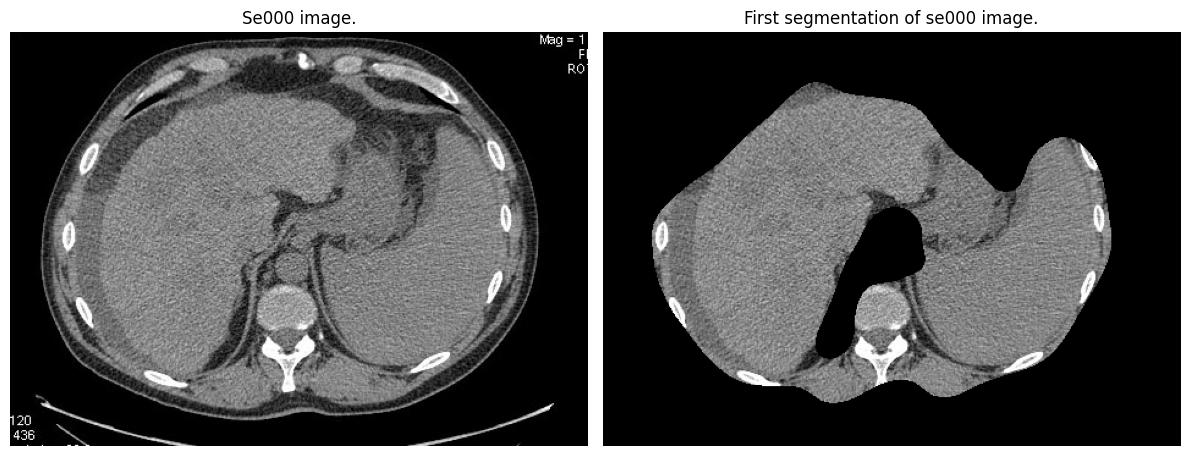

In [2]:
#Load image
image_se000 = Image.open("C:\\Users\\sofyc\\OneDrive\\Desktop\\UPEC\\Pattern recognition\\assignment 8 - IP\\IP7\\IP7\\se000.jpg").convert('L') # Conversion to grayscale

#To array
image_array_se000 = np.array(image_se000)

#Structuring element for Erosion
struct_el_v4 = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
#Erosion
eroded_v4_se000 = cv2.erode(image_array_se000, struct_el_v4, iterations=1)

#Median filter
median_filtered_se000 = cv2.medianBlur(eroded_v4_se000, 9)

#Calculating the average intensity for the threshold with a positive and negative offset
mean_intensity_se000 = np.mean(median_filtered_se000)
upper_threshold_se000 = mean_intensity_se000 + 25  #Positive offset
lower_threshold_se000 = mean_intensity_se000 - 25  #Negative offset

#Creating the first binary mask based on the first threshold
binary_mask_1 = np.where((median_filtered_se000 >= lower_threshold_se000) & (median_filtered_se000 <= upper_threshold_se000), 1, 0).astype(np.uint8)

#Finding the largest contour
largest_contour_se000 = image_array_se000 * binary_mask_1
largest_contour_se000 = image_array_se000 - largest_contour_se000 #Difference
largest_contour_se000 = cv2.erode(largest_contour_se000, struct_el_v4, iterations=2) #Second erosion
largest_contour_se000 = opening(largest_contour_se000, disk(3)) #Opening

#Function for Otsu thresholding
def otsu_method(img):
    otsu_threshold = threshold_otsu(img)
    # Binarization based on Otsu’s method
    binary_image = (img > otsu_threshold).astype(np.uint8)
    return binary_image, otsu_threshold

#Binarization: Otsu’s thresholding is used in place of MATLAB’s graythresh()
BW_se000, level_se000 = otsu_method(largest_contour_se000) #Second thresholding
BW_se000 = image_array_se000 * BW_se000

#Application of a median filter with a 49x49 window
median_filtered2_se000 = cv2.medianBlur(BW_se000, 49)

#Application of a Gaussian filter with a 51x51 window
gaussian_filtered2_se000 = cv2.GaussianBlur(median_filtered2_se000, (51, 51), 0)

#Calculating the average intensity for the third threshold
mean_intensity2_se000 = np.mean(gaussian_filtered2_se000)
threshold3_mask = np.where(gaussian_filtered2_se000 > mean_intensity2_se000, 1, 0).astype(np.uint8)

#Cleaning the mask with morphological operations
struct_el_large = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
largest_contour2_se000 = closing(threshold3_mask, struct_el_large) #Closing
largest_contour2_se000 = opening(largest_contour2_se000, struct_el_large) #Opening

#Application of the final mask to the image
segmented_se000 = cv2.bitwise_and(image_array_se000, image_array_se000, mask=largest_contour2_se000.astype(np.uint8))

#Plot
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(image_se000, cmap='gray', norm=NoNorm())
ax[0].set_title("Se000 image.")
ax[0].axis('off')

ax[1].imshow(segmented_se000, cmap='gray')
ax[1].set_title("First segmentation of se000 image.")
ax[1].axis('off')

plt.tight_layout()
plt.show()

##### 1.2. Try to segment the liver from the image se000.jpeg, what method do you choose, why?

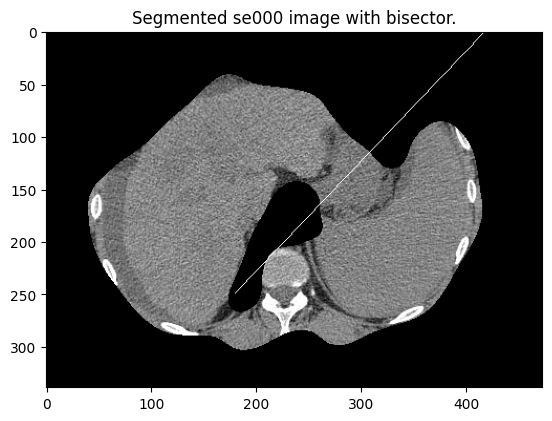

In [13]:
#Dimensions of the image
height, width = segmented_se000.shape

#Creating a horizontal bisector (horizontal central line)
segmented_se000_delimited = segmented_se000.copy()

#Bisector coordinates (lower-right position)
start_point = (180, height - 90)  #Starting point
end_point = (width + 40, -100)   #Ending point

#Drawing the bisector
cv2.line(segmented_se000_delimited, start_point, end_point, (255, 0, 0), 1)

#Plot
plt.imshow(segmented_se000_delimited, cmap='gray')
plt.title("Segmented se000 image with bisector.")
plt.show()

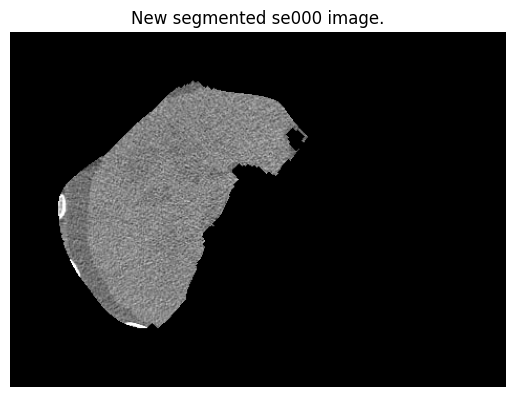

In [16]:
#Zero out the pixels below the bisector (part to the right of the line)
for y in range(height):
    for x in range(width):
        #Condition: only if the point is below the bisector
        if x > (y - start_point[1]) * (end_point[0] - start_point[0]) / (end_point[1] - start_point[1]) + start_point[0]:
            segmented_se000_delimited[y, x] = 0

#Application of erosion
segmented_se000_delimited = cv2.erode(segmented_se000_delimited, struct_el_v4, iterations=3)

#Application of Otsu's thresholding
segmented_se000_delimited, _ = otsu_method(segmented_se000_delimited)

#Application of the binary mask with the original image
segmented_liver_se000 = image_array_se000 * segmented_se000_delimited

#Plot of the modified image with zero values below the bisector
plt.imshow(segmented_liver_se000, cmap='gray')
plt.title("New segmented se000 image.")
plt.axis('off')
plt.show()

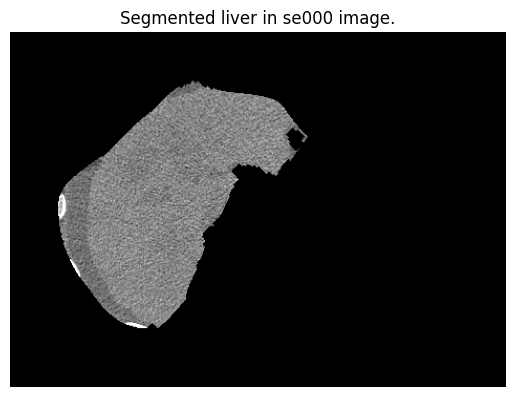

In [17]:
#Dimensions of the image
height, width = segmented_liver_se000.shape

#Creating a new horizontal bisector
se000_new_bisector = segmented_liver_se000.copy()
#New bisector coordinates (lower-right position)
start_point = (255, height - 195)
end_point = (width + 30, -200)

#Drawing the bisector
cv2.line(se000_new_bisector, start_point, end_point, (255, 0, 0), 1)

#Setting all values below the bisector to 0
segmented_liver2_se000 = segmented_liver_se000.copy()

#Zero out the pixels below the bisector as done before
for y in range(height):
    for x in range(width):
        #Condition: only if the point is below the bisector
        if x > (y - start_point[1]) * (end_point[0] - start_point[0]) / (end_point[1] - start_point[1]) + start_point[0]:
            segmented_liver2_se000[y, x] = 0

#Plot
plt.imshow(segmented_liver2_se000, cmap='gray')
plt.title("Segmented liver in se000 image.")
plt.axis('off')
plt.show()

### 2. Edge function 
##### Now, use directly edge to extract edges in an image with different options. Be sure now that two steps - maxima extraction and thresholding - are used to define the ‘edges’. 
##### 2.1. Applications 
##### First, try to detect all the edges of the T image. Is there any method that seems better? 
##### Download the image of toy building blocks bricks, try to detect all the edges of the image. Try to detect firstly the edges for the blue bricks, and then for the red ones. Try now to detect all the edges of the images skin. Is it possible to isolate only salient edges, that is to say those which delimitate each homogeneous part?

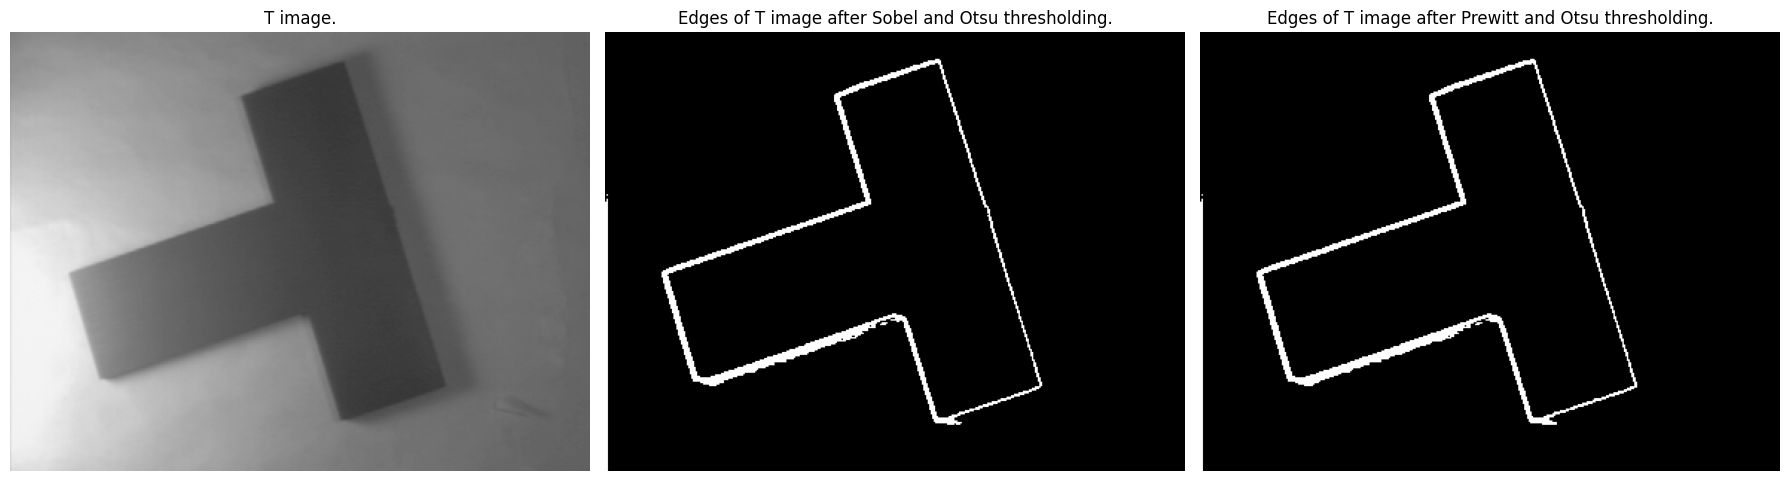

In [150]:
#Load image
image_T = Image.open("C:\\Users\\sofyc\\OneDrive\\Desktop\\UPEC\\Pattern recognition\\assignment 8 - IP\\IP7\\IP7\\T.png").convert('L') #Conversion to grayscale

#To array
image_array_T = np.array(image_T)

#Since edge() function is for MatLab, here in Python we can use Canny, Sobel, Prewitt and other methods.
#Maxima extraction: Application of Sobel for edge detection
edges_sobel_image_T = filters.sobel(image_array_T)
#Maxima extraction: Application of Prewitt for edge detection
edges_prewitt_image_T = filters.prewitt(image_array_T)

#Thresholding: Binarization to get the edges more clearly
binary_sobel_image_T, otsu_threshold_sobel_T = otsu_method(edges_sobel_image_T)
binary_prewitt_image_T, otsu_threshold_prewitt_T = otsu_method(edges_prewitt_image_T)

#Plot
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

#Original image
ax[0].imshow(image_array_T, cmap='gray', norm=NoNorm())
ax[0].set_title("T image.")
ax[0].axis('off')

#Edges of T image - Sobel
ax[1].imshow(binary_sobel_image_T, cmap='gray')
ax[1].set_title("Edges of T image after Sobel and Otsu thresholding.")
ax[1].axis('off')

#Edges of T image - Prewitt
ax[2].imshow(binary_prewitt_image_T, cmap='gray')
ax[2].set_title("Edges of T image after Prewitt and Otsu thresholding.")
ax[2].axis('off')

plt.tight_layout()
plt.show()

c:\Users\sofyc\OneDrive\Desktop\environment for NN and ML\myenv\Lib\site-packages\skimage\exposure\exposure.py:306: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  hist, bin_edges = np.histogram(image, bins=bins, range=hist_range)


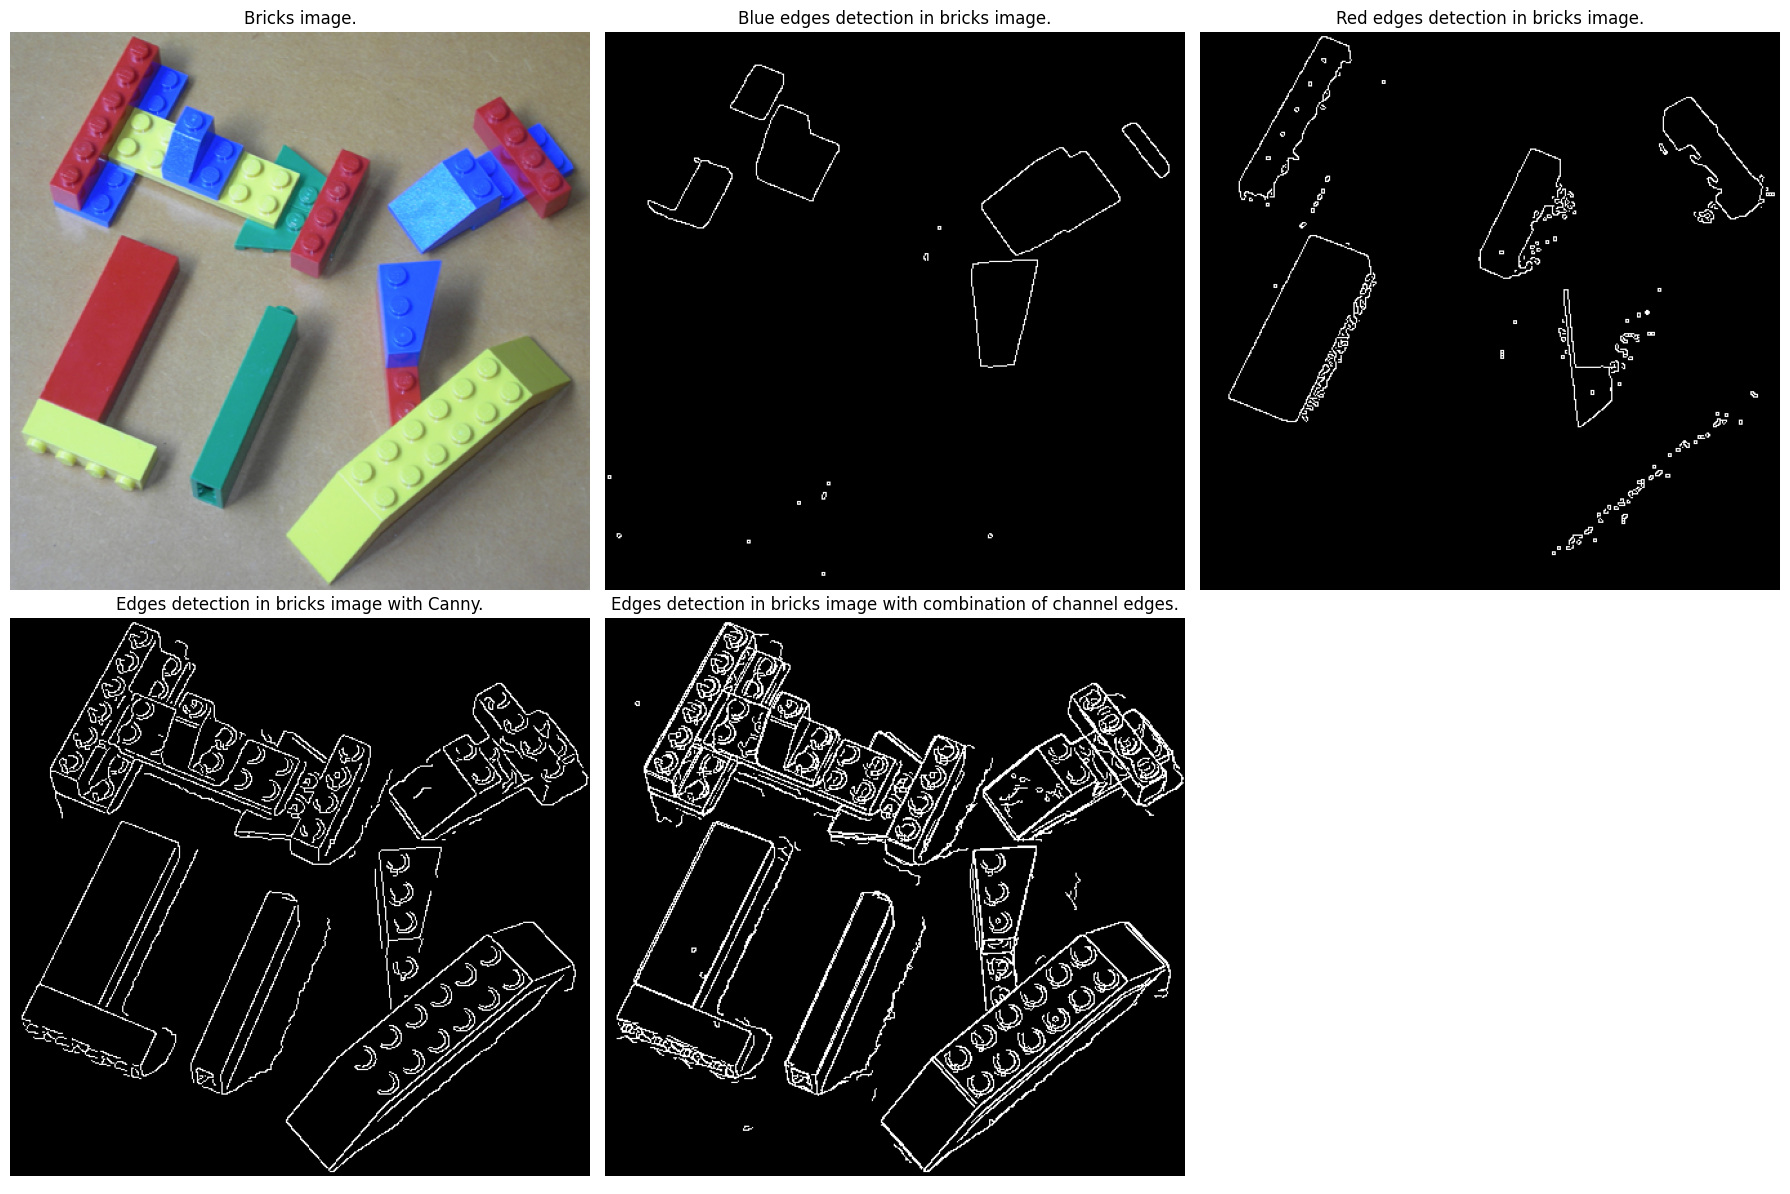

In [140]:
#Load image
image_bricks = Image.open("C:\\Users\\sofyc\\OneDrive\\Desktop\\UPEC\\Pattern recognition\\assignment 8 - IP\\IP7\\IP7\\bricks.jpg")

#To array
image_array_bricks = np.array(image_bricks)

#Conversion RGB to HSV
#- Hue : [0 ,1]. As hue increases from 0 to 1, the color transitions from red to orange, yellow, green, cyan, blue, magenta, and finally back to red.
#- Saturation : [0 ,1]. 0 = neutral shade , 1 = maximum saturation.
#- Value : maximum value among the red, green, and blue components of a specific color.
hsv_bricks = rgb2hsv(image_array_bricks)
#Extraction of Hue and Saturation channels
hue = hsv_bricks[:, :, 0]  #Hue channel
saturation = hsv_bricks[:, :, 1]  #Saturation channel

#Thresholds for blue in HSV space:
#The Hue range has 360 degrees. The color blue goes more or less between 194 to 252 degrees . Hence, 194/360 = 0.54 , while 252/360 = 0.70.
lower_hue_blue = 0.54
upper_hue_blue = 0.70

#Thresholds for red in HSV space:
#Red colo has two intervals:
#- the first interval goes more or less between 0 to 60 degrees . Hence, 0/360 = 0.0 , while 60/360 = 0.17;
#- the second interval goes more or less between 315 to 360 degrees . Hence, 315/360 = 0.86 , while 360/360 = 1.
lower_hue_red1 = 0.0
upper_hue_red1 = 0.05
lower_hue_red2 = 0.875
upper_hue_red2 = 1.0

minimum_saturation = 0.1 # Minimum saturation to exclude white/bright pixels --> 0.1 after some trials.

#Masks for blue and red points in the image
blue_mask = (hue >= lower_hue_blue) & (hue <= upper_hue_blue) & (saturation >= minimum_saturation)
red_mask = ((hue >= lower_hue_red1) & (hue <= upper_hue_red1) | (hue >= lower_hue_red2) & (hue <= upper_hue_red2)) & (saturation >= minimum_saturation)

#Here we use Canny method: application of Canny for edge detection
edges_blue = feature.canny(blue_mask)
edges_red = feature.canny(red_mask)

#Now for the last part of the task regarding salient edges detection of the entire image, we use 2 methods.
#METHOD 1:
#First we transform the image into grayscale
gray_image_bricks = rgb2gray(image_array_bricks)

#Maxima extraction: Application of Canny for edge detection
edges_image_bricks = feature.canny(gray_image_bricks)

#Thresholding: Binarization to get the edges more clearly
binary_edges_image_bricks, otsu_threshold_edges_bricks = otsu_method(edges_image_bricks)

#METHOD 2:
#We extract separately the channels from the image array
R_bricks = image_array_bricks[:, :, 0] #red
G_bricks = image_array_bricks[:, :, 1] #green
B_bricks = image_array_bricks[:, :, 2] #blue

#Maxima extraction: Application of Canny for edge detection
edges_R_bricks = feature.canny(R_bricks)
edges_G_bricks = feature.canny(G_bricks)
edges_B_bricks = feature.canny(B_bricks)

#Now we combine the three edges from the three channels, in order to obtain the final edge
all_edges_bricks = np.maximum(np.maximum(edges_R_bricks, edges_G_bricks), edges_B_bricks)
#Thresholding: Binarization to get the edges more clearly
all_edges_bricks, tr_method2 = otsu_method(all_edges_bricks)

#Plot
fig, ax = plt.subplots(2, 3, figsize=(18, 12))

#Original image
ax[0, 0].imshow(image_array_bricks)
ax[0, 0].set_title("Bricks image.")
ax[0, 0].axis('off')

#Blue edges
ax[0, 1].imshow(edges_blue, cmap='gray')
ax[0, 1].set_title("Blue edges detection in bricks image.")
ax[0, 1].axis('off')

#Red edges
ax[0, 2].imshow(edges_red, cmap='gray')
ax[0, 2].set_title("Red edges detection in bricks image.")
ax[0, 2].axis('off')

#Edges METHOD 1
ax[1, 0].imshow(binary_edges_image_bricks, cmap='gray')
ax[1, 0].set_title("Edges detection in bricks image with Canny.")
ax[1, 0].axis('off')

#Edges METHOD 2
ax[1, 1].imshow(all_edges_bricks, cmap='gray')
ax[1, 1].set_title("Edges detection in bricks image with combination of channel edges.")
ax[1, 1].axis('off')

#Hiding the last subplot since it is not present
ax[-1, -1].axis('off')

plt.tight_layout()
plt.show()

### 3. Canny detector 
##### The Canny detector is based on this gradient vector. During the previous section with the image T, if you missed the Canny’s method, try it as the results are generally better.

(-0.5, 389.5, 294.5, -0.5)

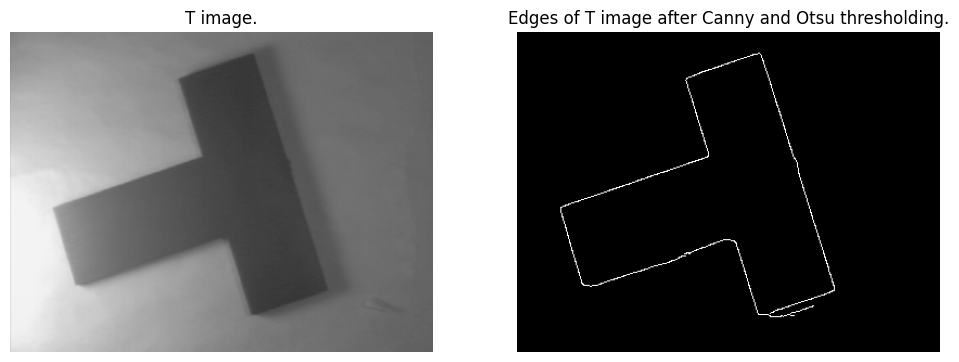

In [145]:
#Maxima extraction: Application of Canny for edge detection
edges_canny_image_T = feature.canny(image_array_T)

#Thresholding: Binarization to get the edges more clearly
binary_canny_image_T, otsu_threshold_canny_T = otsu_method(edges_canny_image_T)

#Plot
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

#Original image
ax[0].imshow(image_array_T, cmap='gray', norm=NoNorm())
ax[0].set_title("T image.")
ax[0].axis('off')

#Edges of T image - Canny
ax[1].imshow(binary_canny_image_T, cmap='gray')
ax[1].set_title("Edges of T image after Canny and Otsu thresholding.")
ax[1].axis('off')

## REFERENCES
- https://www.researchgate.net/figure/Stages-of-image-processing-a-initial-image-b-threshold-segmentation-isolation-of_fig1_226709970
- https://stackoverflow.com/questions/16057023/an-opencv-function-similar-to-matlabs-graythresh